In [1]:
import pickle as pl
import numpy as np
import pandas as pd
import os
import sys
from plotnine import *

os.chdir("/Users/cornederuijt/github/GCM/")
# To check whether Jupyter is using the correct kernel (should be the anaconda environment)
# print(sys.executable)
# print(sys.path)
gcm_res = pl.load(open("./data/small_example/state_prob.pl", "rb"))
click_entr = pl.load(open("./data/small_example/convergence.pl", "rb"))
click_probs = pl.load(open("./data/small_example/click_probs.pl", "rb"))


In [2]:
# ! which jupyter
# ! which jupyter-notebook
# !jupyter kernelspec list w

In [3]:
phi_A_all = []
gamma_all = []
for param_val in gcm_res:
    phi_A_all.append(param_val['phi_A'].reshape(-1, 1))
    gamma_all.append(param_val['gamma'].reshape(10, 49)[:,1].reshape(-1 ,1))

phi_mat = np.hstack(phi_A_all)
gamma_mat = np.hstack(gamma_all)

#phi_mat
#gamma_mat

array([[0.4257217 , 0.4257654 , 0.42580912, 0.42585284, 0.42589656,
        0.42594028, 0.42598403, 0.42602775, 0.42607147, 0.42611519,
        0.4261589 ],
       [0.382645  , 0.38704008, 0.38899773, 0.39050192, 0.39177108,
        0.3928899 , 0.39390182, 0.3948328 , 0.39569956, 0.3965139 ,
        0.3972844 ],
       [0.54631805, 0.5509128 , 0.5529489 , 0.5545091 , 0.55582255,
        0.5569782 , 0.55802166, 0.55898017, 0.55987126, 0.5607074 ,
        0.56149733],
       [0.4163642 , 0.42088193, 0.4228921 , 0.42443585, 0.42573774,
        0.42688495, 0.4279222 , 0.42887616, 0.4297641 , 0.43059805,
        0.43138683],
       [0.5690517 , 0.5735956 , 0.57560766, 0.5771489 , 0.578446  ,
        0.57958686, 0.58061683, 0.5815626 , 0.5824418 , 0.58326656,
        0.5840457 ],
       [0.32956648, 0.33368218, 0.33551848, 0.3369308 , 0.33812323,
        0.33917508, 0.340127  , 0.34100312, 0.3418193 , 0.3425864 ,
        0.34331247],
       [0.6707268 , 0.6748097 , 0.6766121 , 0.67799026, 0.

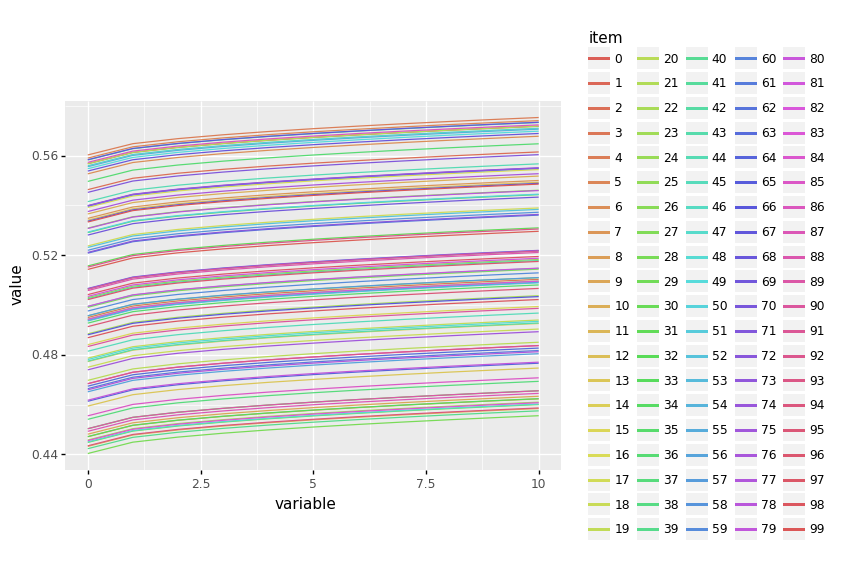

<ggplot: (8768332001166)>

In [4]:
phi_A_pd = pd.DataFrame(phi_mat)
phi_A_pd['item'] = np.arange(phi_A_pd.shape[0])
phi_A_pd = pd.melt(phi_A_pd, id_vars=['item'])
phi_A_pd['variable'] = phi_A_pd['variable'].astype(float)
phi_A_pd['item'] = phi_A_pd['item'].astype('category')

ggplot(phi_A_pd) +\
geom_line(aes(x='variable', y='value', color='item'))


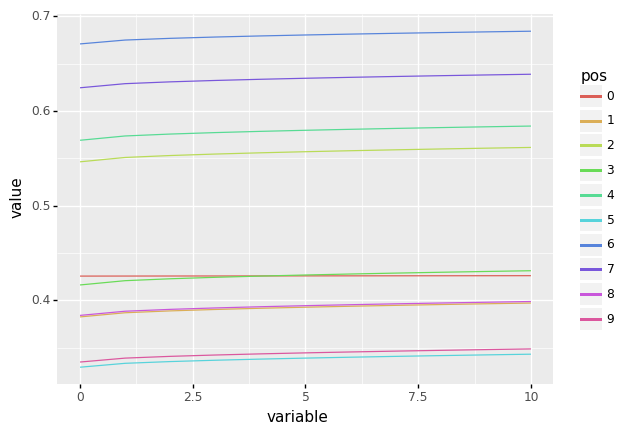

<ggplot: (8768339163359)>

In [5]:
gamma_pd = pd.DataFrame(gamma_mat)
gamma_pd['pos'] = np.arange(gamma_pd.shape[0])
gamma_pd = pd.melt(gamma_pd, id_vars=['pos'])
gamma_pd['pos'] = gamma_pd['pos'].astype('category')
gamma_pd['variable'] = gamma_pd['variable'].astype(float)

gamma_pd
ggplot(gamma_pd) +\
    geom_line(aes(x='variable', y='value', color='pos'))
 


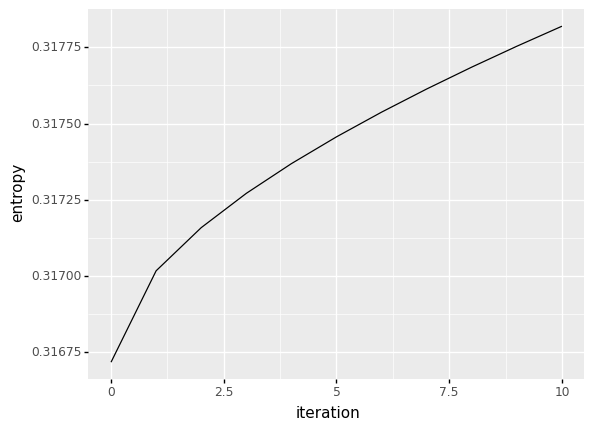

<ggplot: (8768340044788)>

In [11]:
click_entr_pd = pd.DataFrame(click_entr, columns=['entropy'])
click_entr_pd

click_entr_pd['iteration'] = np.arange(click_entr_pd.shape[0])

(ggplot(click_entr_pd) +
 geom_line(aes(x='iteration', y='entropy')) 
)

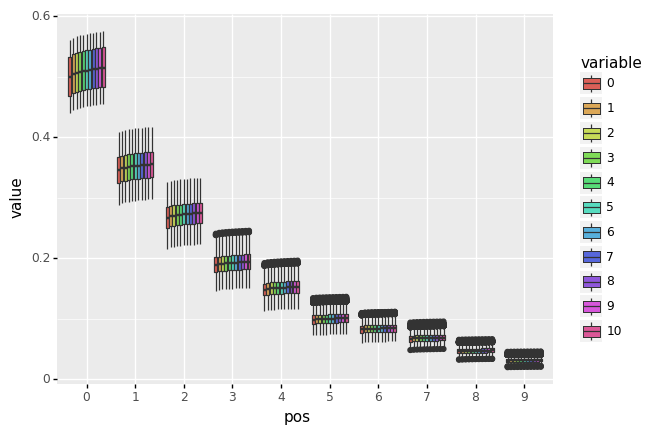

<ggplot: (8768343005519)>

In [32]:
click_probs = [prob.reshape(-1, 1) for prob in click_probs]
click_probs_pd = pd.DataFrame(np.hstack(click_probs))
click_probs_pd['pos'] = np.tile(np.arange(10), int(click_probs_pd.shape[0]/10))
click_probs_pd['pos'] = click_probs_pd['pos'].astype('category')
click_probs_pd

click_probs_pd_flat = pd.melt(click_probs_pd, id_vars=['pos'])
click_probs_pd_flat['variable'] = click_probs_pd_flat['variable'].astype('category')

click_probs_pd_flat

(ggplot(click_probs_pd_flat) +
 geom_boxplot(aes(x='pos', y='value', fill='variable'))
)



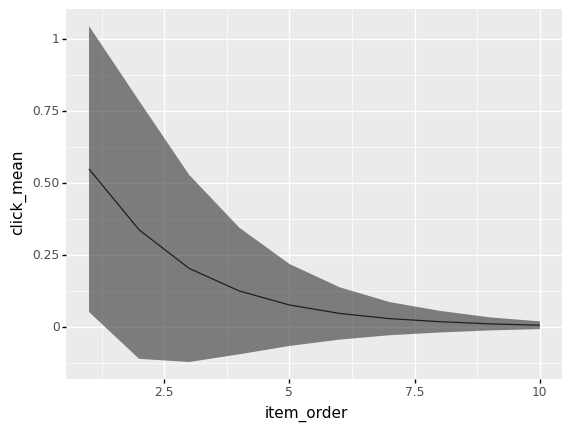

<ggplot: (8768242967796)>

In [44]:
def flatten_index(df):
  df_copy = df.copy()
  df_copy.columns = ['_'.join(col).rstrip('_') for col in df_copy.columns.values]
  return df_copy.reset_index()

real_click = pd.read_csv("./data/small_example/simulation_res_train.csv", index_col=False)
real_click['item_order'] = real_click['item_order'].astype('int')

res = real_click.groupby(['item_order']).agg({'click': ['mean', 'var']}).pipe(flatten_index)
res
res['upper'] = res['click_mean'] + 2*res['click_var']
res['lower'] = res['click_mean'] - 2*res['click_var']

(ggplot(res)+
 geom_line(aes(x='item_order', y='click_mean')) +
 geom_ribbon(aes(x='item_order', ymin='lower', ymax='upper'), alpha = 0.6)
)

In [22]:
def flatten_index(df):
  df_copy = df.copy()
  df_copy.columns = ['_'.join(col).rstrip('_') for col in df_copy.columns.values]
  return df_copy.reset_index()

# Perplexity on the different positions
real_click = pd.read_csv("./data/small_example/simulation_res_train.csv", index_col=False)
real_click_vec = real_click['click'].to_numpy()

pos_entr = []
neg_entr = []

i = 0
for cp in click_probs:
    pos_entr.append((-real_click_vec * np.log(cp)).reshape(-1, 1))
    neg_entr.append((-(1 - real_click_vec) * np.log(1 - cp)).reshape(-1, 1))

pos_entr_full = pd.DataFrame(np.hstack((pos_entr)))
pos_entr_full['pos'] = np.tile(np.arange(10), int(pos_entr_full.shape[0]/10))

neg_entr_full = pd.DataFrame(np.hstack((pos_entr)))
neg_entr_full['pos'] = np.tile(np.arange(10), int(pos_entr_full.shape[0]/10))

pos_entr_pd_plot = pd.melt(pos_entr_full,id_vars=['pos']).groupby(['pos', 'variable']).agg({'value': 'mean'}).\
    pipe(flatten_index)
pos_entr_pd_plot = pos_entr_pd_plot.rename(columns={'v_a_l_u_e': 'value'})
pos_entr_pd_plot['pos'] = pos_entr_pd_plot['pos'].astype('int')
pos_entr_pd_plot['variable'] = pos_entr_pd_plot['variable'].astype('category')

pos_entr_pd_plot.pivot(index='pos', columns='variable', values='value')
#pos_entr_pd_plot.pivot('variable')


variable,0,1,2,3,4,5,6,7,8,9,10
pos,,,,,,,,,,,
0,0.381673,0.376639,0.374406,0.372699,0.371266,0.370007,0.368872,0.367832,0.366865,0.365960,0.365105
1,0.359088,0.356292,0.355048,0.354094,0.353291,0.352584,0.351945,0.351358,0.350813,0.350301,0.349817
2,0.269351,0.267598,0.266816,0.266216,0.265709,0.265262,0.264859,0.264487,0.264141,0.263816,0.263508
3,0.209204,0.208195,0.207743,0.207395,0.207100,0.206839,0.206603,0.206386,0.206183,0.205992,0.205811
4,0.147376,0.146722,0.146429,0.146203,0.146011,0.145842,0.145688,0.145546,0.145414,0.145289,0.145170
5,0.110729,0.110397,0.110246,0.110130,0.110030,0.109942,0.109862,0.109788,0.109718,0.109653,0.109590
6,0.074027,0.073802,0.073700,0.073621,0.073553,0.073494,0.073439,0.073389,0.073342,0.073297,0.073255
7,0.051781,0.051624,0.051553,0.051498,0.051452,0.051410,0.051372,0.051337,0.051304,0.051273,0.051244
8,0.035249,0.035165,0.035127,0.035097,0.035071,0.035049,0.035028,0.035009,0.034991,0.034974,0.034957
